In [6]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline

This notebook uses all the raw data from the masterlist, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. Here we use the SERVS depth.

In [19]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_EGS/data/holes_EGS_irac_i1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu17/dmu17_HELP-SEIP-maps/EGS/data/60088930.60088930-0.MIPS.1.moc.fits')

In [20]:
Final=Sel_func.intersection(SWIRE_MOC)

In [21]:
Final.write('./data/testMoc.fits', overwrite=True)

## Read in Masterlist
Next step is to read in Masterlist and select only sources that are detected in mid-infrared and at least one other wavelength domain (i.e. optical or nir). This will remove most of the objects in the catalogue that are artefacts. We can do this by using the `flag_optnir_det` flag and selecting sources that have a binary value of $>= 5$

In [10]:
from astropy.io import fits
masterfile='master_catalogue_egs_20180501.fits'
masterlist=fits.open('../../dmu1/dmu1_ml_EGS/data/'+masterfile)

In [11]:
good=masterlist[1].data['flag_optnir_det']>=5

In [12]:
good.sum()

134490

### Create uninformative (i.e. conservative) upper and lower limits based on IRAC fluxes
As the default flux prior for XID+ is a uniform distribution, it makes sense to set reasonable upper and lower 24 micron flux limits based on the longest wavelength IRAC flux available. For a lower limit I take IRAC/500.0 and for upper limit I take IRACx500.

In [13]:
MIPS_lower=np.full(good.sum(),0.0)
MIPS_upper=np.full(good.sum(),1E5)

In [ ]:
#masterlist[1].header

In [ ]:
for i in range(0,good.sum()):
    if masterlist[1].data['f_irac_i4'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i4'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i4'][good][i]*500.0
    elif masterlist[1].data['f_irac_i3'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i3'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i3'][good][i]*500.0
    elif masterlist[1].data['f_irac_i2'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i2'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i2'][good][i]*500.0
    elif masterlist[1].data['f_irac_i1'][good][i]>0:
        MIPS_lower[i]=masterlist[1].data['f_irac_i1'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i1'][good][i]*500.0

In [ ]:
#np.savez('./tmp_mips_prior', MIPS_lower, MIPS_upper)

In [14]:
npzfile = np.load('./tmp_mips_prior.npz')
MIPS_lower=npzfile['arr_0']
MIPS_upper=npzfile['arr_1']

## Read in Map
We are now ready to read in the MIPS map


In [15]:
MIPS_Map=fits.open('../../dmu17/dmu17_HELP-SEIP-maps/EGS/data/60088930.60088930-0.MIPS.1.help.fits')

In [16]:
MIPS_Map[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  457                                                  
NAXIS2  =                  456                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'Spitzer Super-Mosaic Pipeline' / Origin of these image data          
CREATOR = 'Spitzer Science Center' / Creator of this FITS file                  
                                                                                
          / TIME AND EXPOSURE INFORMATION                                       
                                                                                
TELESCOP= 'Spitzer '        

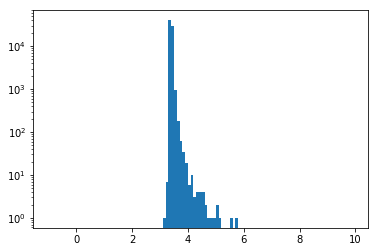

In [17]:
import pylab as plt
data=MIPS_Map[1].data
plt.hist(data.flatten(),bins=np.arange(-1.0,10.0,0.1));
plt.yscale('log')

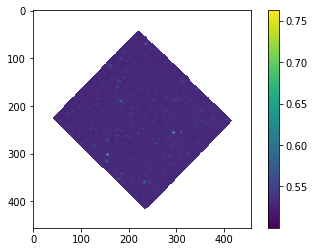

In [18]:
plt.imshow(np.log10(MIPS_Map[1].data))
plt.colorbar()

## Read in PSF

In [22]:
MIPS_psf=fits.open('../../dmu17/dmu17_HELP-SEIP-maps/EGS/data/output_data/dmu17_MIPS_EGS_20190204.fits')

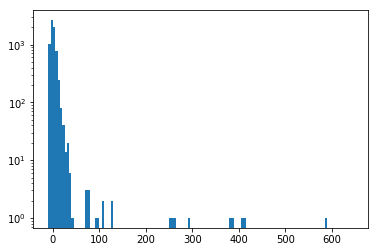

In [23]:
dat=MIPS_psf[1].data
plt.hist(dat.flatten(),bins=np.arange(-10.0,650.0,5.0));
plt.yscale('log')

In [24]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=10

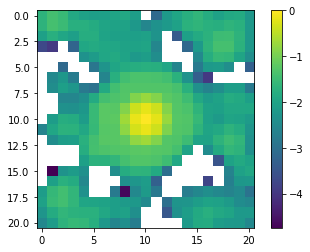

In [25]:

plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

## Set XID+ prior class

In [26]:
prior_MIPS=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=Final)
prior_MIPS.prior_cat(masterlist[1].data['ra'][good],masterlist[1].data['dec'][good],masterfile,flux_lower=MIPS_lower,
                     flux_upper=MIPS_upper,ID=masterlist[1].data['help_id'][good])


keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


In [27]:
prior_MIPS.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))

In [29]:
prior_MIPS.sra

array([], dtype=float64)

In [23]:
xidplus.plot_map([prior_MIPS])


ValueError: zero-size array to reduction operation maximum which has no identity

In [24]:
print(prior_MIPS.sra,prior_MIPS.sdec)

[] []


## Calculate tiles
As fitting the whole map would be too computationally expensive, I split based on HEALPix pixels. For MIPS, the optimum order is 11. So that I don't have to read the master prior based on the whole map into memory each time (which requires a lot more memory) I also create another layer of HEALPix pixels based at the lower order of 6.

In [27]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
order_large=15
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/test/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior_MIPS],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 0 tiles required for input catalogue and 0 large tiles


SystemExit: 

In [28]:
prior_MIPS.nsrc

0